# Imports

In [1]:
import os
from pprint import PrettyPrinter
from typing import Any, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from IPython.display import display
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

RANDOM_STATE = 120623
DATA_DIR = "datasets"
TEST_SIZE = 0.25
MAE_THRESHOLD = 6.8
CV_FOLDS = 5
N_ITERS = 15
VERBOSITY = 0
SCORER = "neg_mean_absolute_error"

# Loading data

In order to have an understanding of what data we will deal with, we will first explore what is contained in `datasets` directory.

In [2]:
cwd_path = os.getcwd()
datasets_path = os.path.join(cwd_path, DATA_DIR)
datasets = os.listdir(datasets_path)
for i, dataset in enumerate(datasets):
    print(f"DATASET #{i + 1}: '{dataset}'")

DATASET #1: 'data_arc_new.csv'
DATASET #2: 'data_bulk_new.csv'
DATASET #3: 'data_bulk_time_new.csv'
DATASET #4: 'data_gas_new.csv'
DATASET #5: 'data_temp_new.csv'
DATASET #6: 'data_wire_new.csv'
DATASET #7: 'data_wire_time_new.csv'


We see that there 7 datasets in total. We will need to read each one of them into a separate DataFrame. For that, we will find the path to each of these datasets and will read the data from them into DataFrames.

In [3]:
data_arc_path = os.path.join(datasets_path, datasets[0])
data_bulk_path = os.path.join(datasets_path, datasets[1])
data_bulk_time_path = os.path.join(datasets_path, datasets[2])
data_gas_path = os.path.join(datasets_path, datasets[3])
data_temp_path = os.path.join(datasets_path, datasets[4])
data_wire_path = os.path.join(datasets_path, datasets[5])
data_wire_time_path = os.path.join(datasets_path, datasets[6])

data_arc = pd.read_csv(data_arc_path)
data_bulk = pd.read_csv(data_bulk_path)
data_bulk_time = pd.read_csv(data_bulk_time_path)
data_gas = pd.read_csv(data_gas_path)
data_temp = pd.read_csv(data_temp_path)
data_wire = pd.read_csv(data_wire_path)
data_wire_time = pd.read_csv(data_wire_time_path)

**Conclusion**

In this small section, we have managed to successfully load the data into the DataFrames. Besides, we have looked inside the folder with data and figured out that we will need to conduct this project using 7 separate datasets.

# Primary data analysis

## General info

Let's get to know the data we have just uploaded. We will write a function called `check_data()` that will print a set number of rows as well as provide a summary of the DataFrame.

In [4]:
def check_data(
    data: pd.DataFrame,
    rows_to_display: int = 5,
    random_state: Optional[int] = None,
) -> Any:
    """Provides an overview of the data.

    Prints a particular number of rows from
    the DataFrame as well as provides its
    concise summary.

    Args:
        data (pd.DataFrame): DataFrame which needs to
            be described.
        rows_to_display (int, optional): Number of rows that
            are printed. Defaults to 5.
        random_state (Optional[int], optional): Number responsible for
            calibrating random numbers generator. Defaults to None.
    """
    # If not None, print random 5 rows + summary
    if random_state is not None:
        display(data.sample(rows_to_display, random_state=random_state))
        data.info()
        return
    # Print the first 5 rows + summary otherwise
    display(data.head(rows_to_display))
    data.info()

We will call this function for each DataFrame separately.

In [5]:
check_data(data=data_arc, random_state=RANDOM_STATE)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
7815,1691,2019-07-05 15:42:30,2019-07-05 15:46:35,0.921549,0.616374
5688,1237,2019-06-19 05:39:16,2019-06-19 05:41:22,0.736196,0.566402
13504,2931,2019-08-26 19:52:09,2019-08-26 19:53:25,1.156500,0.886416
14791,3222,2019-09-06 01:01:15,2019-09-06 01:03:50,0.885109,0.659246
2356,507,2019-05-22 23:01:47,2019-05-22 23:04:46,1.056734,0.834186


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
check_data(data=data_bulk, random_state=RANDOM_STATE)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
755,789,27.0,NaN,NaN,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,268.0,NaN,258.0,NaN
700,733,NaN,NaN,93.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2743,2846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.0,NaN,18.0,NaN
2804,2910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0,NaN,246.0,NaN
368,394,NaN,NaN,NaN,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,157.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [7]:
check_data(data=data_bulk_time, random_state=RANDOM_STATE)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
755,789,2019-06-03 05:19:12,NaN,NaN,2019-06-03 05:14:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-03 05:04:41,NaN,2019-06-03 04:51:23,NaN
700,733,NaN,NaN,2019-06-01 00:08:47,2019-06-01 00:06:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2743,2846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-23 12:11:00,NaN,2019-08-23 12:04:37,NaN
2804,2910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-26 00:23:44,NaN,2019-08-26 00:33:33,NaN
368,394,NaN,NaN,NaN,2019-05-18 17:52:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-18 17:52:55,NaN,2019-05-18 17:43:11,2019-05-18 17:37:55


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [8]:
check_data(data=data_gas, random_state=RANDOM_STATE)

,key,Газ 1
704,707,16.325309
2752,2755,8.916598
303,306,8.757273
2545,2548,8.365139
1889,1892,18.688388


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [9]:
check_data(data=data_temp, random_state=RANDOM_STATE)

,key,Время замера,Температура
4880,866,2019-06-06 07:28:26,1618.0
8039,1439,2019-06-26 12:12:56,1611.0
7135,1277,2019-06-20 17:02:31,1588.0
10746,1922,2019-07-19 10:37:54,1585.0
6102,1088,2019-06-14 05:37:35,1609.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [10]:
check_data(data=data_wire, random_state=RANDOM_STATE)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
285,308,88.757758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2892,3051,75.173279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2262,2380,90.155517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1051,1117,51.058800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2463,2590,114.092163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [11]:
check_data(data=data_wire_time, random_state=RANDOM_STATE)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
285,308,2019-05-15 07:59:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2892,3051,2019-08-31 05:29:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2262,2380,2019-08-06 09:42:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1051,1117,2019-06-15 01:39:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2463,2590,2019-08-14 03:16:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


We notice hereby the following peculiarities of the data:
    
    1. Most DataFrames have a number of missing values. This is not true for only `data_arc` and `data_gas` DataFrames which include all values.
    2. The next problem which is immediately seen is that the names of columns do not correspond to the usual way of column naming (latin small letters as well as underscores). The column names seen here are quite inconvenient to read and may lead to errors.
    3. We can also see that columns containing dates are of `object` datatype, while we would actually like to work with them as with dates.

## Missing values

At the previous stage we have noticed a number of missing values in the DataFrames. Let's write a function called `identify_missing_values()` which will output a table with column names where there are missing values as well as the share of missing values.

In [12]:
def identify_missing_values(data: pd.DataFrame) -> Optional[pd.DataFrame]:
    """Performs missing values computation.

    Computes a number and share of missing values
    in DataFrame columns which have NaN-values present
    and displays data types of such columns.

    Args:
        data (pd.DataFrame): DataFrame which needs to
            be checked for missing values.

    Returns:
        Optional[pd.DataFrame]: DataFrame with column names, number of
        missing values and shares of NaN-values in such columns.
        In case there are not missing values present, an according
        message is shown and nothing is returned. Additionally, columns
        data type is shown.
    """
    # Verifying missing values
    miss_vals_num = data.isnull().sum()[data.isnull().sum() > 0]
    if miss_vals_num.empty:
        print("Missing values have not been found.")
        return

    # Creating a table with numbers of missing values
    cols = {"missing_count": miss_vals_num.values}
    nans_df = pd.DataFrame(data=cols, index=miss_vals_num.index).sort_values(
        by="missing_count", ascending=False
    )

    # Adding a share of missing values
    nans_df["missing_fraction"] = nans_df["missing_count"] / data.shape[0]
    nans_df["missing_fraction"] = nans_df["missing_fraction"].round(4)

    # Adding column datatypes
    nans_df["dtype"] = data[nans_df.index].dtypes
    nans_df = nans_df[["dtype", "missing_count", "missing_fraction"]]

    return nans_df

As with the previous function, we will test this function on all DataFrames.

In [13]:
identify_missing_values(data=data_arc)

Missing values have not been found.


In [14]:
identify_missing_values(data=data_bulk)

,dtype,missing_count,missing_fraction
Bulk 8,float64,3128,0.9997
Bulk 13,float64,3111,0.9942
Bulk 9,float64,3110,0.9939
Bulk 2,float64,3107,0.9930
Bulk 7,float64,3104,0.9920
Bulk 5,float64,3052,0.9754
Bulk 10,float64,2953,0.9438
Bulk 11,float64,2952,0.9434
Bulk 1,float64,2877,0.9195
Bulk 6,float64,2553,0.8159


In [15]:
identify_missing_values(data=data_bulk_time)

,dtype,missing_count,missing_fraction
Bulk 8,object,3128,0.9997
Bulk 13,object,3111,0.9942
Bulk 9,object,3110,0.9939
Bulk 2,object,3107,0.9930
Bulk 7,object,3104,0.9920
Bulk 5,object,3052,0.9754
Bulk 10,object,2953,0.9438
Bulk 11,object,2952,0.9434
Bulk 1,object,2877,0.9195
Bulk 6,object,2553,0.8159


In [16]:
identify_missing_values(data=data_gas)

Missing values have not been found.


In [17]:
identify_missing_values(data=data_temp)

,dtype,missing_count,missing_fraction
Температура,float64,3427,0.1894


In [18]:
identify_missing_values(data=data_wire)

,dtype,missing_count,missing_fraction
Wire 5,float64,3080,0.9997
Wire 7,float64,3070,0.9964
Wire 4,float64,3067,0.9955
Wire 8,float64,3062,0.9938
Wire 9,float64,3052,0.9906
Wire 3,float64,3018,0.9796
Wire 6,float64,3008,0.9763
Wire 2,float64,2002,0.6498
Wire 1,float64,26,0.0084


In [19]:
identify_missing_values(data=data_wire_time)

,dtype,missing_count,missing_fraction
Wire 5,object,3080,0.9997
Wire 7,object,3070,0.9964
Wire 4,object,3067,0.9955
Wire 8,object,3062,0.9938
Wire 9,object,3052,0.9906
Wire 3,object,3018,0.9796
Wire 6,object,3008,0.9763
Wire 2,object,2002,0.6498
Wire 1,object,26,0.0084


As evidenced above, some DataFrame possess quite a large number of missing values. Some tables are free of missing values but still the problem of missing values is quite serious in other DataFrames which will be dealt with during the following sections.

## Duplicates

Now, just in case, we will check the data for duplicates using a new function called `preprocess_duplicates()`. In case of duplicated rows being presented in the data, the function will delete them and inform us of the deletion. Otherwise, it will show a respective message.

In [20]:
def preprocess_duplicates(data: pd.DataFrame) -> Optional[pd.DataFrame]:
    """Computes and deletes all duplicates in the DataFrame.

    Args:
        data (pd.DataFrame): DataFrame which needs to
            be checked for identical rows.
    """
    num_duplicates = data.duplicated().sum()
    if num_duplicates != 0:
        data.drop_duplicates(inplace=True)
        print(f"{num_duplicates:,} duplicates found and deleted.")
    else:
        print("No duplicates found.")

In [21]:
dataframes = (
    data_arc,
    data_bulk,
    data_bulk_time,
    data_gas,
    data_temp,
    data_wire,
    data_wire_time,
)
for i, data in enumerate(dataframes):
    print(f"DATASET {i + 1}:")
    preprocess_duplicates(data=data)

DATASET 1:
No duplicates found.
DATASET 2:
No duplicates found.
DATASET 3:
No duplicates found.
DATASET 4:
No duplicates found.
DATASET 5:
No duplicates found.
DATASET 6:
No duplicates found.
DATASET 7:
No duplicates found.


As can be seen, we have datasets with unique rows.

**Conclusion**

This section was dedicated to the primary data analysis which enabled us to get familiarized with the data, understand missing values problem as well as confirm the absence of duplicated rows.

# Exploratory data analysis

Next step is to carry out exploratory data analysis and for that we will write a function called `plot_hist_data()` that will plot a histogram of a given DataFrame and compute its descriptive statistics.

In [22]:
sns.set_theme(style="darkgrid")

In [23]:
def plot_hist_data(data: pd.DataFrame, figsize: Tuple[int, int] = (15, 20)) -> Any:
    """Plots histograms and computes descriptive statistics.

    Args:
        data (pd.DataFrame): DataFrame for which a set
            of histograms needs to be plotted.
        figsize (Tuple[int, int]): Figure size.
            Defaults to (15, 20).
    """
    # Building histograms
    data.hist(figsize=figsize)
    plt.show()

    # Computing descriptive statistics
    display(data.describe().T)

## Arc

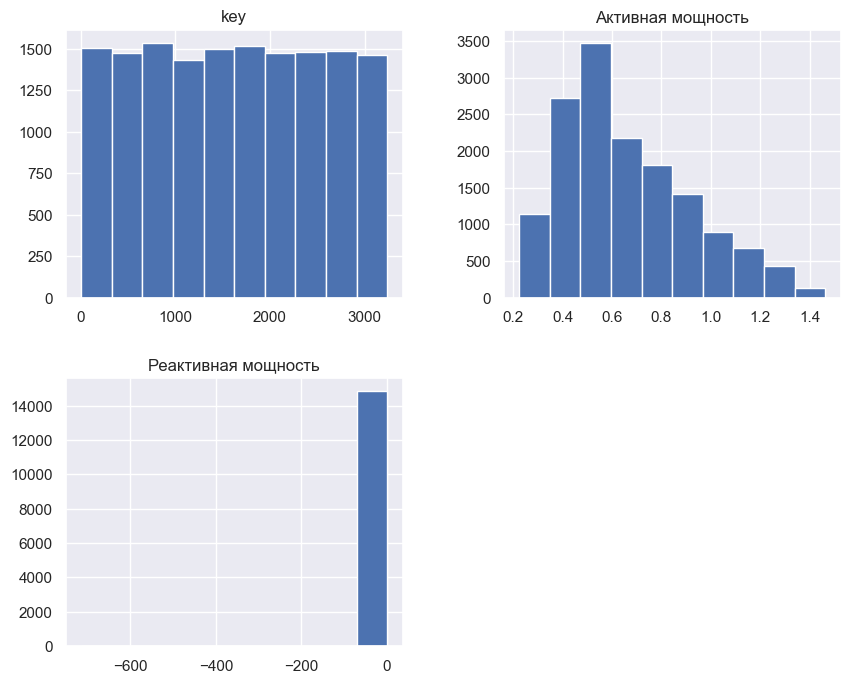

,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773
Реактивная мощность,14876.0,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284


In [24]:
plot_hist_data(data=data_arc, figsize=(10, 8))

Now we see some results for dataset for arc heating. `Активная мощность` refer to *Active capacity* while `Реактивная мощность` - *Reactive capacity*. We will deal with column names during data preprocessing stage. 

*Active capacity* column is characterized by a distribution close to normal, albeit a right-skewed one. We can also see it by a larger value of a mean in comparison with that of a median. Interesting results can be seen on the third histograms where there is certainly something going on. This can also be seen based on the standard deviation and minimum/maximum values.

Now, let's understand whether there are any outliers.

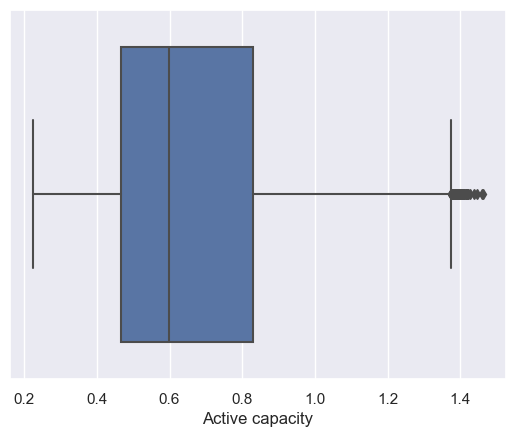

In [25]:
sns.boxplot(x=data_arc["Активная мощность"])
plt.xlabel("Active capacity")
plt.show()

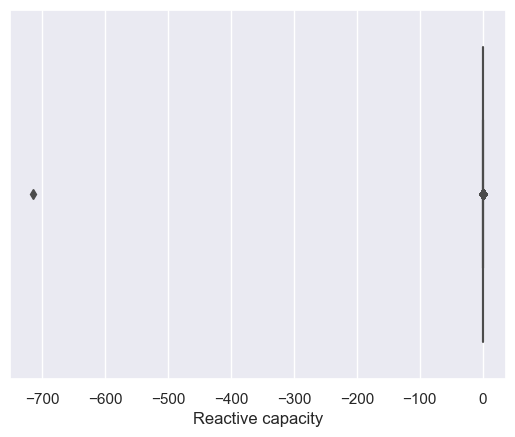

In [26]:
sns.boxplot(x=data_arc["Реактивная мощность"])
plt.xlabel("Reactive capacity")
plt.show()

There is a certain number of outliers for *Active capacity* but a more interesting boxplot is that of *Reactive capacity* where there is certainly an unknown outlier around the values of about -710.  

## Bulk

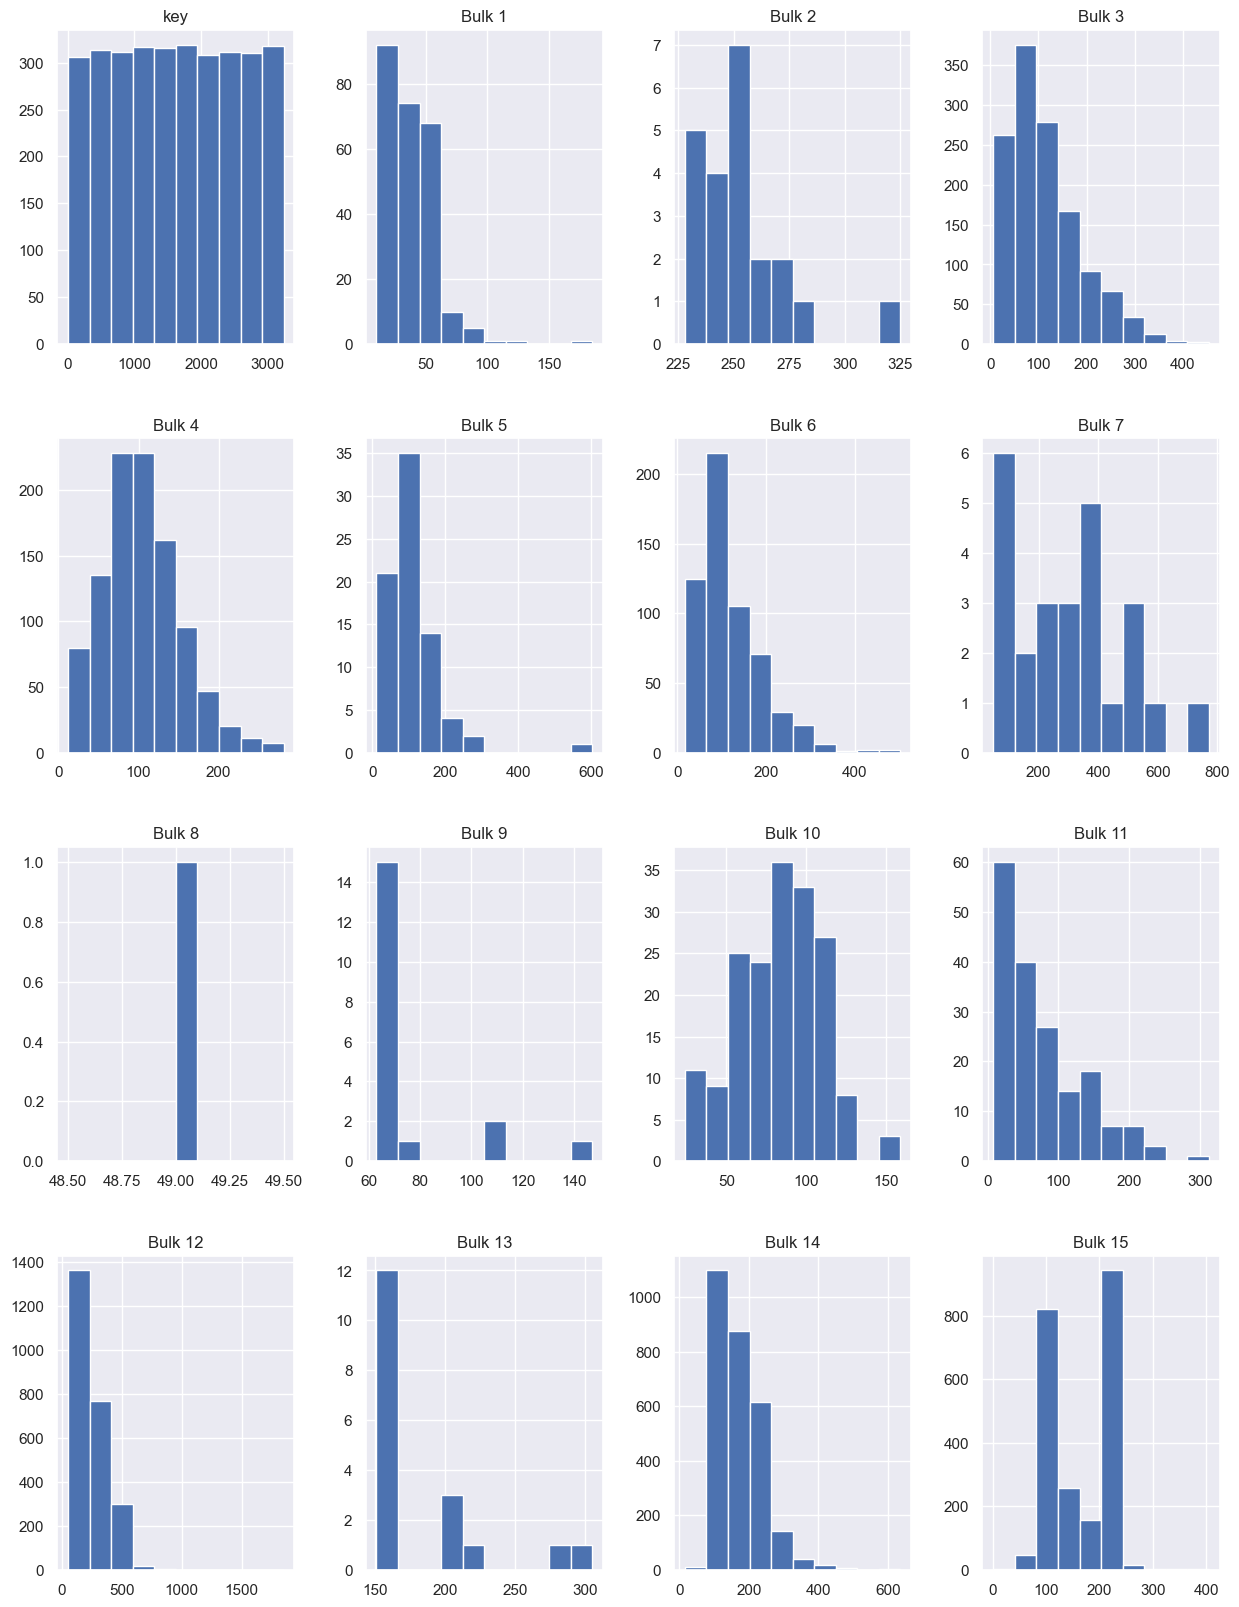

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


In [27]:
plot_hist_data(data=data_bulk)

Histrograms are generally characterized by right-skewed distributions. It can also be noted that due to a high number of missing values we do not get really informative histograms.

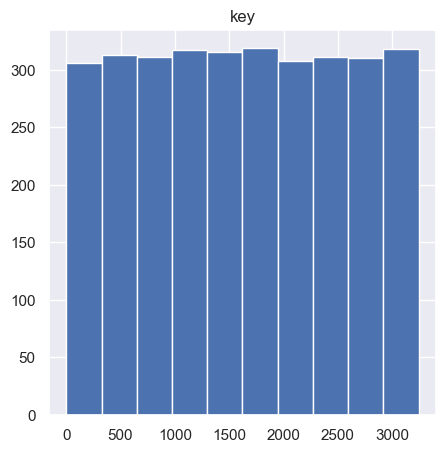

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


In [28]:
plot_hist_data(data=data_bulk_time, figsize=(5, 5))

This DataFrame consists of dates and therefore we can just see identifiers of ladels on the factory.

## Gas

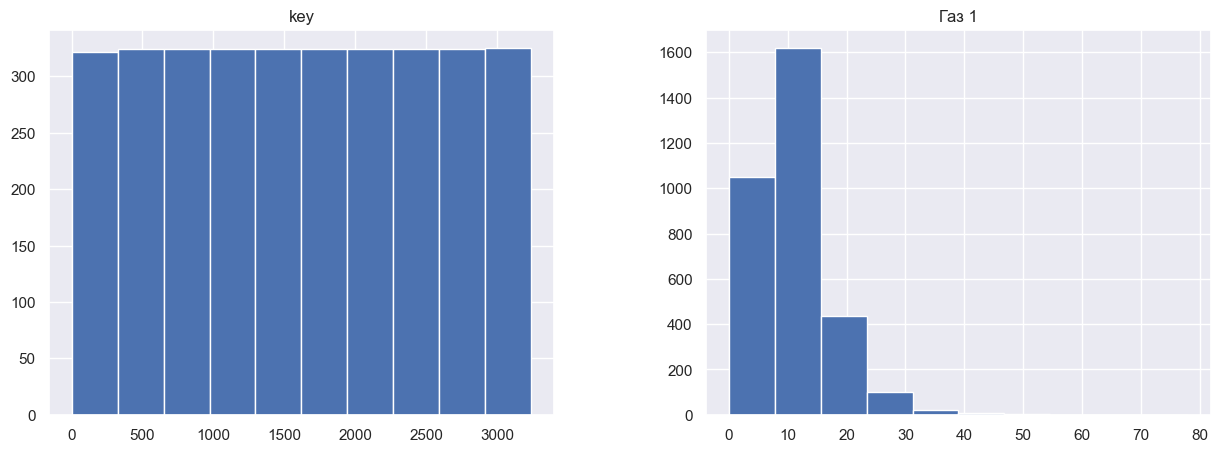

,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


In [29]:
plot_hist_data(data=data_gas, figsize=(15, 5))

Let's consider data on gas. Distribution is rightly skewed and there are possibly some outliers here. Let's verify this hypothesis.

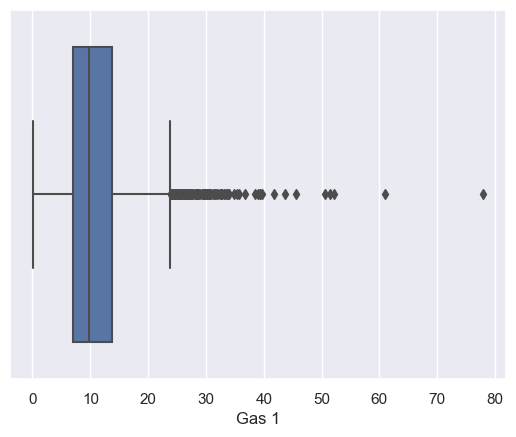

In [30]:
sns.boxplot(x=data_gas["Газ 1"])
plt.xlabel("Gas 1")
plt.show()

There is indeed a certain number of outliers. However, it does not necessarily mean that deleting them will enable a better modeling process. These can be a part of the production process and therefore they require an additional consideration.

## Temperature

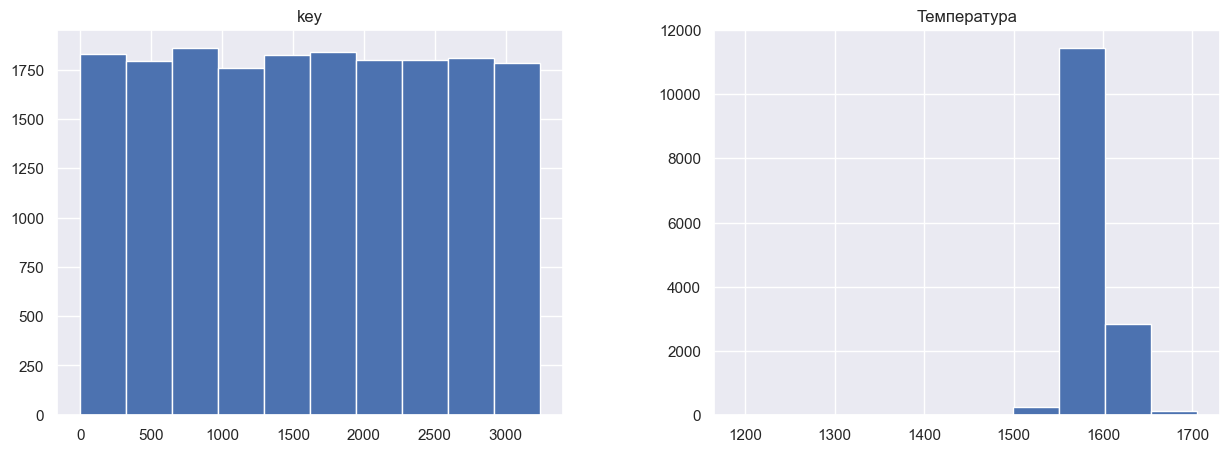

,count,mean,std,min,25%,50%,75%,max
key,18092.0,1616.460977,934.641385,1.0,807.75,1618.0,2429.0,3241.0
Температура,14665.0,1590.722741,20.394381,1191.0,1580.00,1590.0,1599.0,1705.0


In [31]:
plot_hist_data(data=data_temp, figsize=(15, 5))

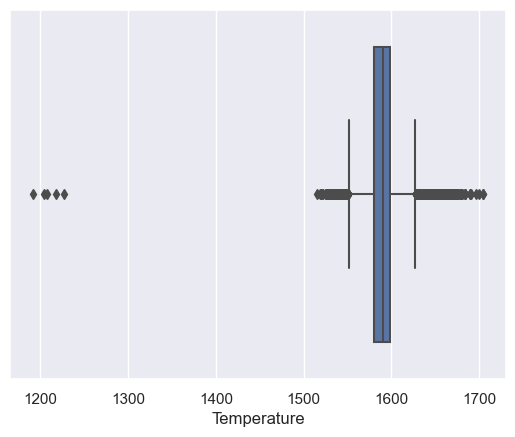

In [32]:
sns.boxplot(x=data_temp["Температура"])
plt.xlabel("Temperature")
plt.show()

Outliers here are quite interesting. The melting temperature of the metal is about 1,400 degrees Celsius. These positive devitations from this value can signify overheating, whereas the values seen here around 1,200 can indeed be outliers, since in this case metal would not reach the required temperature to be melted.

## Wire

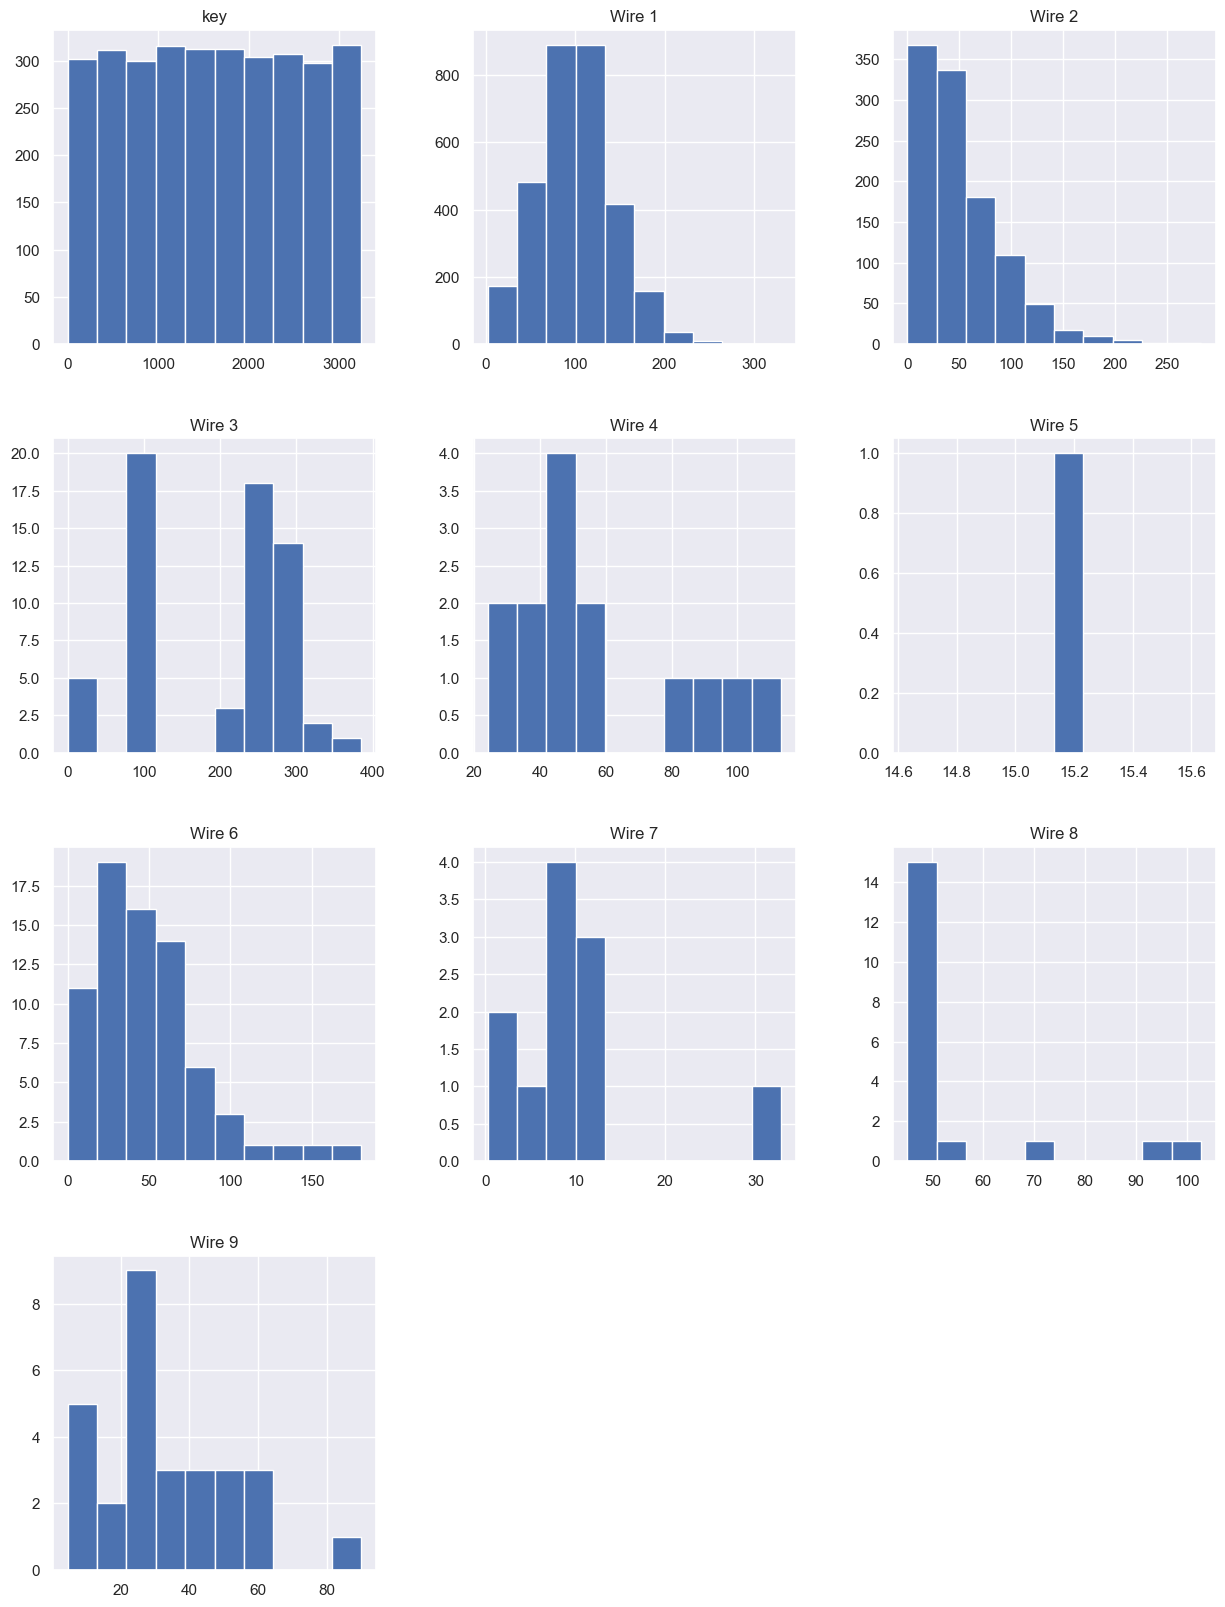

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


In [33]:
plot_hist_data(data=data_wire)

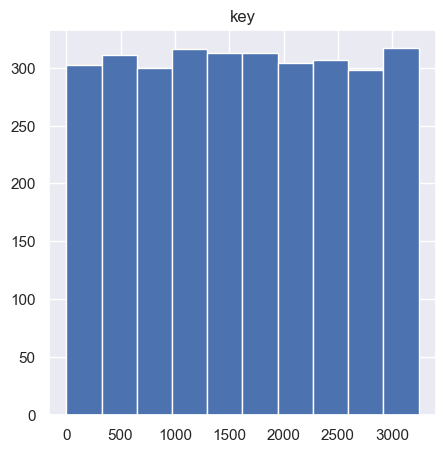

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


In [34]:
plot_hist_data(data=data_wire_time, figsize=(5, 5))

Nothing particularly interesting here.

**Conclusion**

In the process of conducting exploratory data analysis, we were able to identify the following features in the data. In most cases, we are dealing with the right skewness of the distributions of the values of the numerical columns, which was also seen in the positive difference between the mean and median. Furthermore, with the help of boxplots, we were able to determine the presence of outliers for individual columns, which can potentially worsen the performance of the model, which will have to be dealt with.

# Data preprocessing

We now move on to data preprocessing. In this section we will deal with incorrect column names as well as data types. Missing values will also be preprocessed and we will also try to solve the problem of outliers and potential anomalies. 

## Column names

### Capital letters and underscores

We have seen in some DataFrames (for example, in `data_bulk`) that some column have capital letters as well as spaces. We will solve this problem by writing `adjust_column_names()` function that will replace spaces with underscores and will make uppercase letters lowercase.

In [35]:
def adjust_column_names(data: pd.DataFrame) -> pd.DataFrame:
    """Changed column names."""
    data_cols_adj = data.rename(columns=lambda col: col.lower().replace(" ", "_"))

    return data_cols_adj

We will use this function on the following DataFrames:

* `data_bulk`
* `data_bulk_time`
* `data_wire`
* `data_wire_time`

In [36]:
data_bulk = adjust_column_names(data=data_bulk)
display(data_bulk.columns)

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [37]:
data_bulk_time = adjust_column_names(data=data_bulk_time)
display(data_bulk_time.columns)

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [38]:
data_wire = adjust_column_names(data=data_wire)
display(data_wire.columns)

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [39]:
data_wire_time = adjust_column_names(data=data_wire_time)
display(data_wire_time.columns)

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

### Renaming to English

There are also DataFrame which columns do not only have incorrect names but also are written in Russian. Let's rename them to English in a correct way. It relates to the following DataFrames:

* `data_arc`
* `data_gas`
* `data_temp`

#### `data_arc`

In [40]:
display(data_arc.columns)

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')

In [41]:
data_arc = data_arc.rename(
    columns={
        "Начало нагрева дугой": "arc_heating_start",
        "Конец нагрева дугой": "arc_heating_end",
        "Активная мощность": "active_capacity",
        "Реактивная мощность": "reactive_capacity",
    }
)
display(data_arc.columns)

Index(['key', 'arc_heating_start', 'arc_heating_end', 'active_capacity',
       'reactive_capacity'],
      dtype='object')

#### `data_gas`

In [42]:
display(data_gas.columns)

Index(['key', 'Газ 1'], dtype='object')

In [43]:
data_gas = data_gas.rename(
    columns={
        "Газ 1": "gas_1",
    }
)
display(data_gas.columns)

Index(['key', 'gas_1'], dtype='object')

#### `data_temp`

In [44]:
display(data_temp.columns)

Index(['key', 'Время замера', 'Температура'], dtype='object')

In [45]:
data_temp = data_temp.rename(
    columns={"Время замера": "measure_time", "Температура": "temperature"}
)
display(data_temp.columns)

Index(['key', 'measure_time', 'temperature'], dtype='object')

## Data types

Now, we will fix data types in some DataFrames where dates are specified as `object`. The DataFrames to be adjusted:

* `data_bulk_time`
* `data_wire_time`
* `data_arc`
* `data_temp`

### `data_*_time`

In [46]:
for data in (data_bulk_time, data_wire_time):
    for col in data.columns:
        if col != "key":
            data[col] = pd.to_datetime(data[col], format="%Y-%m-%d %H:%M:%S")

In [47]:
check_data(data=data_bulk_time, rows_to_display=3)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [48]:
check_data(data=data_wire_time, rows_to_display=3)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


### `data_arc`

In [49]:
data_arc["arc_heating_start"] = pd.to_datetime(
    data_arc["arc_heating_start"], format="%Y-%m-%d %H:%M:%S"
)
data_arc["arc_heating_end"] = pd.to_datetime(
    data_arc["arc_heating_end"], format="%Y-%m-%d %H:%M:%S"
)

In [50]:
check_data(data=data_arc, rows_to_display=3)

,key,arc_heating_start,arc_heating_end,active_capacity,reactive_capacity
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   arc_heating_start  14876 non-null  datetime64[ns]
 2   arc_heating_end    14876 non-null  datetime64[ns]
 3   active_capacity    14876 non-null  float64       
 4   reactive_capacity  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


### `data_temp`

In [51]:
data_temp["measure_time"] = pd.to_datetime(
    data_temp["measure_time"], format="%Y-%m-%d %H:%M:%S"
)

In [52]:
check_data(data=data_temp, rows_to_display=3)

,key,measure_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   measure_time  18092 non-null  datetime64[ns]
 2   temperature   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


## Outliers

During exploratory data analysis we have identified a number of outliers. Let's try to preprocess them. The following DataFrame will be fixed:

* `data_temp`
* `data_arc`

### `data_temp`

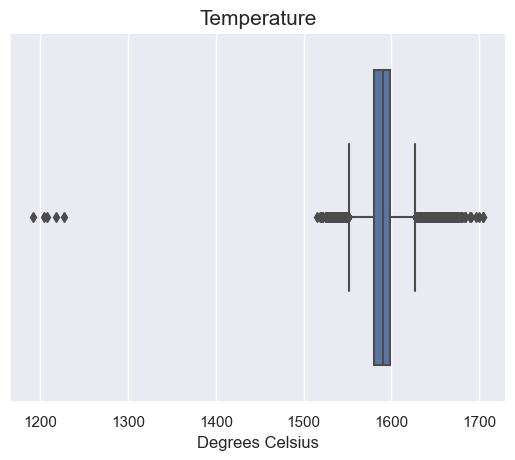

In [53]:
sns.boxplot(data=data_temp, x="temperature")
plt.title("Temperature", fontsize=15)
plt.xlabel("Degrees Celsius")
plt.show()

In this diagram, we see temperature values, among which there is a number of values that seem to be implausible. The melting point of the metal is 1,400 degrees Celsius, and at such values, the metal would simply not melt. Let's look at such values in the data.

In [54]:
temp_outliers = data_temp[data_temp["temperature"] < 1400]
display(temp_outliers)

,key,measure_time,temperature
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


Indeed, these 5 values are immediately seen in the boxplot above. Let's get rid of them.

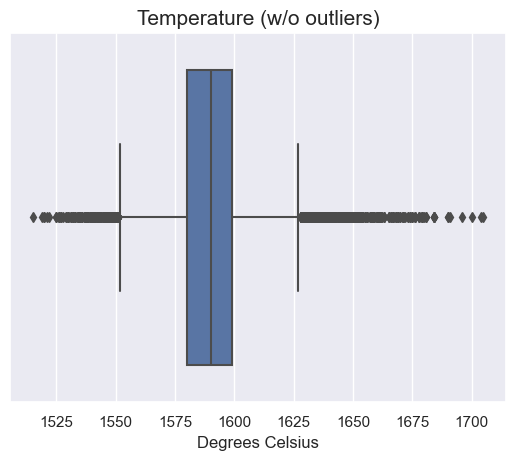

In [55]:
data_temp.drop(temp_outliers.index, inplace=True)

sns.boxplot(data=data_temp, x="temperature")
plt.title("Temperature (w/o outliers)", fontsize=15)
plt.xlabel("Degrees Celsius")
plt.show()

### `data_arc`

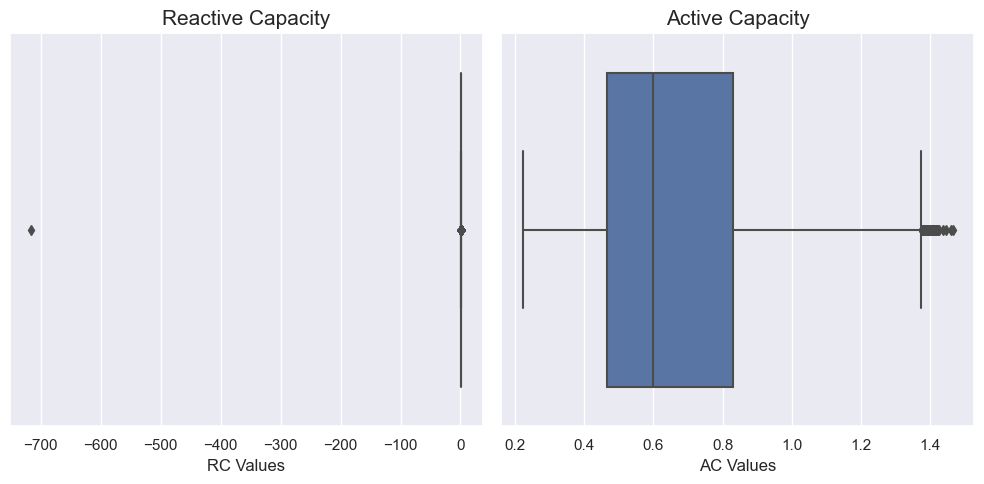

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(5 * 2, 5 * 1))

sns.boxplot(data=data_arc, x="reactive_capacity", ax=axes[0])
axes[0].set_title("Reactive Capacity", fontsize=15)
axes[0].set_xlabel("RC Values")

sns.boxplot(data=data_arc, x="active_capacity", ax=axes[1])
axes[1].set_title("Active Capacity", fontsize=15)
axes[1].set_xlabel("AC Values")

plt.tight_layout()
plt.show()

There is nothing particularly interesting about *Active Capacity* but, however, we again notice this peculiar outlier on the boxplot of *Reactive Capacity*.

In [57]:
rc_outliers = data_arc[data_arc["reactive_capacity"] < 0]
display(rc_outliers)

,key,arc_heating_start,arc_heating_end,active_capacity,reactive_capacity
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


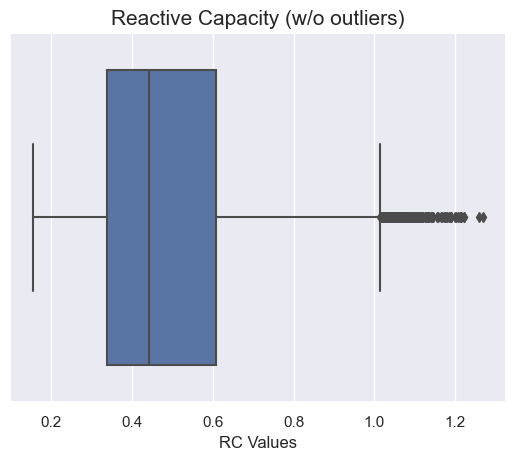

In [58]:
data_arc.drop(rc_outliers.index, inplace=True)

sns.boxplot(data=data_arc, x="reactive_capacity")
plt.title("Reactive Capacity (w/o outliers)", fontsize=15)
plt.xlabel("RC Values")
plt.show()

## Missing values

### `data_arc`, `data_gas`

In [59]:
identify_missing_values(data=data_arc)

Missing values have not been found.


In [60]:
identify_missing_values(data=data_gas)

Missing values have not been found.


### `data_temp`

In [61]:
identify_missing_values(data=data_temp)

,dtype,missing_count,missing_fraction
temperature,float64,3427,0.1895


We see about 19% of values of those in `data_temp` are missing. Let's see what these represent.

In [62]:
data_temp_nans = data_temp[data_temp["temperature"].isna() == True]
display(data_temp_nans)

,key,measure_time,temperature
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


From this table it seems that data for all ladle numbers starting from 2,500 have missing values. Let's verify if this is actually true.

In [63]:
ladle_numbers_nan = data_temp_nans["key"].sort_values().unique()
display(ladle_numbers_nan)

array([2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510,
       2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521,
       2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532,
       2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543,
       2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554,
       2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
       2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576,
       2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587,
       2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598,
       2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609,
       2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620,
       2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631,
       2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642,
       2643, 2644, 2645, 2646, 2647, 2648, 2649, 26

We notice that this is indeed true. Let's look at some of the ladles in the data.

In [64]:
ladle_rand_num_1 = np.random.choice(ladle_numbers_nan)
display(data_temp[data_temp["key"] == ladle_rand_num_1])

,key,measure_time,temperature
14919,2665,2019-08-16 21:37:04,1564.0
14920,2665,2019-08-16 21:40:51,NaN
14921,2665,2019-08-16 21:47:20,NaN
14922,2665,2019-08-16 21:52:52,NaN


In [65]:
ladle_rand_num_2 = np.random.choice(ladle_numbers_nan)
display(data_temp[data_temp["key"] == ladle_rand_num_2])

,key,measure_time,temperature
14452,2584,2019-08-13 23:28:13,1580.0
14453,2584,2019-08-13 23:33:14,NaN
14454,2584,2019-08-13 23:44:25,NaN
14455,2584,2019-08-13 23:49:51,NaN
14456,2584,2019-08-13 23:55:40,NaN
14457,2584,2019-08-14 00:04:40,NaN
14458,2584,2019-08-14 00:11:04,NaN


In [66]:
ladle_rand_num_3 = np.random.choice(ladle_numbers_nan)
display(data_temp[data_temp["key"] == ladle_rand_num_3])

,key,measure_time,temperature
16427,2934,2019-08-26 21:45:45,1605.0
16428,2934,2019-08-26 21:50:57,NaN
16429,2934,2019-08-26 22:02:57,NaN
16430,2934,2019-08-26 22:07:34,NaN
16431,2934,2019-08-26 22:22:35,NaN
16432,2934,2019-08-26 22:25:52,NaN
16433,2934,2019-08-26 22:31:13,NaN


In [67]:
ladle_rand_num_4 = np.random.choice(ladle_numbers_nan)
display(data_temp[data_temp["key"] == ladle_rand_num_4])

,key,measure_time,temperature
15754,2817,2019-08-22 12:30:51,1612.0
15755,2817,2019-08-22 12:44:33,NaN
15756,2817,2019-08-22 12:54:17,NaN
15757,2817,2019-08-22 13:11:58,NaN
15758,2817,2019-08-22 13:22:12,NaN
15759,2817,2019-08-22 13:30:13,NaN


We note that such batches are characterized by the presence of only the initial temperature, but not the final one. It is possible that these batches are still in the process of metal processing. In other words, the final temperature, which is our target, is not given for these batches and filling in such gaps with anything will lead to the fact that our model can learn to draw conclusions on false and thus counterfactual data, so we have nothing left to do but get rid of those gaps. We can simply filter the DataFrame for the first 2499 batches.

In [68]:
data_temp = data_temp[data_temp["key"] < 2500]

In [69]:
identify_missing_values(data=data_temp)

Missing values have not been found.


### `data_bulk`, `data_wire`

In [70]:
identify_missing_values(data=data_bulk)

,dtype,missing_count,missing_fraction
bulk_8,float64,3128,0.9997
bulk_13,float64,3111,0.9942
bulk_9,float64,3110,0.9939
bulk_2,float64,3107,0.9930
bulk_7,float64,3104,0.9920
bulk_5,float64,3052,0.9754
bulk_10,float64,2953,0.9438
bulk_11,float64,2952,0.9434
bulk_1,float64,2877,0.9195
bulk_6,float64,2553,0.8159


In [71]:
identify_missing_values(data=data_wire)

,dtype,missing_count,missing_fraction
wire_5,float64,3080,0.9997
wire_7,float64,3070,0.9964
wire_4,float64,3067,0.9955
wire_8,float64,3062,0.9938
wire_9,float64,3052,0.9906
wire_3,float64,3018,0.9796
wire_6,float64,3008,0.9763
wire_2,float64,2002,0.6498
wire_1,float64,26,0.0084


There is quite a large number of gaps here. However, they can be easily dealt with if remembering that the data in these two DataFrames include additives that may not be used, for example, in a particular batch. In other words, we can simply replace gaps with zeros.

In [72]:
for data in (data_wire, data_bulk):
    data.fillna(0, inplace=True)

In [73]:
identify_missing_values(data=data_bulk)

Missing values have not been found.


In [74]:
identify_missing_values(data=data_wire)

Missing values have not been found.


In [75]:
for data in (data_arc, data_gas, data_temp, data_wire, data_bulk):
    nan_num = np.sum(data.isna().sum())
    assert nan_num == 0

We have managed to get rid of missing values. Missing values in `data_bulk_time` and `data_bulk_wire` are not that interesting for us, since this data is not particularly information for modeling.

## Anomalies

Now, let's see if there are any anomalies in our data. In particular, we can check for two kinds of anomalies:

1. Both `data_bulk` and `data_wire` additives must be used in the production process. It cannot be that nothing is used or only one of them is. The probability of obtaining an ideal chemical composition is extremely small, so we will consider such batches to be of low quality.

2. The batch must be purged with gas, so these with zero gas volume values are also bad.

### `data_bulk`

In [76]:
data_bulk_check = data_bulk.set_index("key")
data_bulk_check.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [77]:
data_bulk_sum = data_bulk_check.sum(axis=1)
data_bulk_sum[data_bulk_sum == 0]

Series([], dtype: float64)

### `data_wire`

In [78]:
data_wire_check = data_wire.set_index("key")
data_wire_check.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
data_wire_sum = data_wire_check.sum(axis=1)
data_wire_sum[data_wire_sum == 0]

Series([], dtype: float64)

### `data_gas`

In [80]:
data_gas[data_gas["gas_1"] == 0]

,key,gas_1


**Conclusion**

This section was used to preprocess the data we have in the best possible way. We managed to fix column names as well as incorrect data types. We got rid of outliers, missing values as well as verified the data for anomalies.

# Feature engineering

This section will be dedicated to creating new features to be used in the modeling process. This might help boosting the performance of the model as well as enable a better inference.

## Recovering target variable

We will first deal with the target variable, meaning that we need to have it separately defined so that we could use it to train the model. In our case target is located in `data_temp` where values in question relate to the very last temperature value within a particular ladle number.

In [81]:
data_temp.head(22)

,key,measure_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


The object of study is a ladle, so we need to have one temperature value per batch. In this case, we are simply interested in the last batch temperature. This can be done in many ways, but here we simply sort the data first by the `key` column with batches and the time column `measure_time` to make sure we have consistent times within each batch. Next, we simply remove the duplicates in the `key` column and leave the last duplicate (by setting `keep="last"`), which is essentially the batch number with the last sample. To make it easier to merging data later, we will always henceforth index each DataFrame by `key`.

In [82]:
data_final_temp = (
    data_temp.sort_values(by=["key", "measure_time"])
    .drop_duplicates(subset=["key"], keep="last")
    .set_index("key")
)

data_final_temp = data_final_temp.rename(columns={"temperature": "final_temp"})

data_final_temp.head(4)

,measure_time,final_temp
key,,
1,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:55:09,1602.0
3,2019-05-03 12:35:57,1599.0
4,2019-05-03 12:59:47,1625.0


We can check the data obtained with the data in `data_temp` to make sure that we have indeed correctly recovered the value of the target variable.

In [83]:
try:
    data_final_temp = data_final_temp.drop(["measure_time"], axis=1)
except KeyError:
    print("Column has been deleted. Execute the previous column once again.")
else:
    check_data(data=data_final_temp)

,final_temp
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   final_temp  2477 non-null   float64
dtypes: float64(1)
memory usage: 38.7 KB


## Initial temperature

Now, we will almost exactly the same as we did in the previous point but will have to leave not the last but the first duplicate. Intermediate temperatures are unlikely to carry much value to the modeling part.

In [84]:
data_temp.head(22)

,key,measure_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [85]:
data_init_temp = (
    data_temp.sort_values(by=["key", "measure_time"])
    .drop_duplicates(subset=["key"], keep="first")
    .set_index("key")
)

data_init_temp = data_init_temp.rename(columns={"temperature": "init_temp"})

data_init_temp.head(4)

,measure_time,init_temp
key,,
1,2019-05-03 11:02:04,1571.0
2,2019-05-03 11:34:04,1581.0
3,2019-05-03 12:06:44,1596.0
4,2019-05-03 12:39:27,1601.0


In [86]:
try:
    data_init_temp = data_init_temp.drop(["measure_time"], axis=1)
except KeyError:
    print("Column has been deleted. Execute the previous column once again.")
else:
    check_data(data=data_init_temp, random_state=None)

,init_temp
key,
1,1571.0
2,1581.0
3,1596.0
4,1601.0
5,1576.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   init_temp  2477 non-null   float64
dtypes: float64(1)
memory usage: 38.7 KB


## Additional features from `data_arc`

Let's look at this DataFrame and think of what features we can create here.

In [87]:
data_arc.sample(5, random_state=RANDOM_STATE)

,key,arc_heating_start,arc_heating_end,active_capacity,reactive_capacity
7815,1691,2019-07-05 15:42:30,2019-07-05 15:46:35,0.921549,0.616374
5688,1237,2019-06-19 05:39:16,2019-06-19 05:41:22,0.736196,0.566402
13504,2931,2019-08-26 19:52:09,2019-08-26 19:53:25,1.156500,0.886416
14791,3222,2019-09-06 01:01:15,2019-09-06 01:03:50,0.885109,0.659246
2356,507,2019-05-22 23:01:47,2019-05-22 23:04:46,1.056734,0.834186


For instance, we can think of different ways of accounting for the capacity:

1. One of the possible indicators is called $cos(\phi)$ which can be computed as follows:

$$
cos(\phi) = \frac{AC}{TC},
$$
where $AC$ is *Active Capacity* and $TC$ - *Total Capacity*.

2. Another indicator is the aforementioned *Total Capacity*:

$$
TC = \sqrt{AC^2 + RC^2},
$$
where $RC$ is *Reactive Capacity*.

3. We can also compute capacity through work:

$$
W = TC \times THT,
$$
где $W$ is work, а $THT$ - total heating time.

Now, we will create these features and will later understand which of these correlate the most with the target variable. We will not be able to use all three of them for modeling due to potential multicollinearity issues so we will choose some one way of accounting for capacity.

In [88]:
# Computing Total Capacity
data_arc["total_capacity"] = np.sqrt(
    data_arc["active_capacity"] ** 2 + data_arc["reactive_capacity"] ** 2
)

# Computing cos(phi)
data_arc["cos_phi"] = data_arc["active_capacity"] / data_arc["total_capacity"]

# Computing heating time (in seconds)
data_arc["heating_time_sec"] = (
    data_arc["arc_heating_end"] - data_arc["arc_heating_start"]
).dt.seconds

data_arc.head()

,key,arc_heating_start,arc_heating_end,active_capacity,reactive_capacity,total_capacity,cos_phi,heating_time_sec
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,0.822181,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,0.848545,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,0.803161,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,0.806591,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,0.802950,148


Now, we will take the sum of `total_capacity`, mean of `cos_phi` and sum of `heating_time_sec` across all batches.

In [89]:
# Aggegating data across batches
data_add_features = data_arc.groupby("key").agg(
    {"total_capacity": ["sum"], "cos_phi": ["mean"], "heating_time_sec": ["sum"]}
)

# Getting rid of multi-index
data_add_features.columns = ["total_capacity", "cos_phi", "heating_time_sec"]

# Computing work
data_add_features["work"] = (
    data_add_features["total_capacity"] * data_add_features["heating_time_sec"]
)

data_add_features.head()

,total_capacity,cos_phi,heating_time_sec,work
key,,,,
1,3.718736,0.816686,1098,4083.171936
2,2.588349,0.825276,811,2099.150800
3,5.019223,0.809724,655,3287.591368
4,3.400038,0.793923,741,2519.428170
5,2.816980,0.796818,869,2447.955323


In [90]:
try:
    data_add_features = data_add_features.drop(["heating_time_sec"], axis=1)
except KeyError:
    print("Column has already been deleted.")
else:
    check_data(data=data_add_features)

,total_capacity,cos_phi,work
key,,,
1,3.718736,0.816686,4083.171936
2,2.588349,0.825276,2099.150800
3,5.019223,0.809724,3287.591368
4,3.400038,0.793923,2519.428170
5,2.816980,0.796818,2447.955323


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_capacity  3214 non-null   float64
 1   cos_phi         3214 non-null   float64
 2   work            3214 non-null   float64
dtypes: float64(3)
memory usage: 100.4 KB


## Other features

In [91]:
data_gas.set_index("key", inplace=True)
check_data(data=data_gas)

,gas_1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gas_1   3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


In [92]:
data_bulk.set_index("key", inplace=True)
check_data(data=data_bulk)

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bulk_1   3129 non-null   float64
 1   bulk_2   3129 non-null   float64
 2   bulk_3   3129 non-null   float64
 3   bulk_4   3129 non-null   float64
 4   bulk_5   3129 non-null   float64
 5   bulk_6   3129 non-null   float64
 6   bulk_7   3129 non-null   float64
 7   bulk_8   3129 non-null   float64
 8   bulk_9   3129 non-null   float64
 9   bulk_10  3129 non-null   float64
 10  bulk_11  3129 non-null   float64
 11  bulk_12  3129 non-null   float64
 12  bulk_13  3129 non-null   float64
 13  bulk_14  3129 non-null   float64
 14  bulk_15  3129 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


In [93]:
data_wire.set_index("key", inplace=True)
check_data(data=data_wire)

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wire_1  3081 non-null   float64
 1   wire_2  3081 non-null   float64
 2   wire_3  3081 non-null   float64
 3   wire_4  3081 non-null   float64
 4   wire_5  3081 non-null   float64
 5   wire_6  3081 non-null   float64
 6   wire_7  3081 non-null   float64
 7   wire_8  3081 non-null   float64
 8   wire_9  3081 non-null   float64
dtypes: float64(9)
memory usage: 240.7 KB


**Conclusion**

This section was devoted to features engineering, during which we were able to embed new features into these data. In particular, we have added initial temperature, various capacity metrics. In addition, we have some initial features that are also potentially useful. We managed to isolate the target variable and bring the DataFrames into a convenient format thanks to which we can combine all the data into one final table.

# Creating a modeling DataFrame

## Merging data

So, we are ready to combine DataFrames into a final table for modeling. Let's repeat here which DataFrames we need to merge:

     1.data_final_temp
     2.data_init_temp
     3.data_add_features
     4.data_gas
     5.data_bulk
     6.data_wire

When merging data, the resulting table needs to include only those batches that are present in all DataFrames. Therefore, in addition to the fact that the merge will occur by `key` index, which is available for all DataFrames, we will merge by `inner` method.

In [94]:
data_full = (
    data_final_temp.merge(data_init_temp, left_index=True, right_index=True)
    .merge(data_add_features, left_index=True, right_index=True)
    .merge(data_gas, left_index=True, right_index=True)
    .merge(data_bulk, left_index=True, right_index=True)
    .merge(data_wire, left_index=True, right_index=True)
)

check_data(data=data_full)

,final_temp,init_temp,total_capacity,cos_phi,work,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,1613.0,1571.0,3.718736,0.816686,4083.171936,29.749986,0.0,0.0,0.0,43.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1602.0,1581.0,2.588349,0.825276,2099.150800,12.555561,0.0,0.0,0.0,73.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1599.0,1596.0,5.019223,0.809724,3287.591368,28.554793,0.0,0.0,0.0,34.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1625.0,1601.0,3.400038,0.793923,2519.428170,18.841219,0.0,0.0,0.0,81.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1602.0,1576.0,2.816980,0.796818,2447.955323,5.413692,0.0,0.0,0.0,78.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   final_temp      2329 non-null   float64
 1   init_temp       2329 non-null   float64
 2   total_capacity  2329 non-null   float64
 3   cos_phi         2329 non-null   float64
 4   work            2329 non-null   float64
 5   gas_1           2329 non-null   float64
 6   bulk_1          2329 non-null   float64
 7   bulk_2          2329 non-null   float64
 8   bulk_3          2329 non-null   float64
 9   bulk_4          2329 non-null   float64
 10  bulk_5          2329 non-null   float64
 11  bulk_6          2329 non-null   float64
 12  bulk_7          2329 non-null   float64
 13  bulk_8          2329 non-null   float64
 14  bulk_9          2329 non-null   float64
 15  bulk_10         2329 non-null   float64
 16  bulk_11         2329 non-null   float64
 17  bulk_12         2329 non-null   f

## Data preprocessing

In [95]:
identify_missing_values(data=data_full)

Missing values have not been found.


Since in one of the previous sections we have filled in a large number of missing values in columns with zeros, it can very well be that after merging we will have columns consisting entirely of zeros. Let's check this and delete such columns.

In [96]:
for col in data_full.columns:
    if data_full[col].sum() == 0:
        print(f"Column '{col}' consists of zeros.")

Column 'wire_5' consists of zeros.


In [97]:
data_full.drop("wire_5", axis=1, inplace=True)
check_data(data=data_full)

,final_temp,init_temp,total_capacity,cos_phi,work,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,...,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,1613.0,1571.0,3.718736,0.816686,4083.171936,29.749986,0.0,0.0,0.0,43.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1602.0,1581.0,2.588349,0.825276,2099.150800,12.555561,0.0,0.0,0.0,73.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1599.0,1596.0,5.019223,0.809724,3287.591368,28.554793,0.0,0.0,0.0,34.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1625.0,1601.0,3.400038,0.793923,2519.428170,18.841219,0.0,0.0,0.0,81.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,1602.0,1576.0,2.816980,0.796818,2447.955323,5.413692,0.0,0.0,0.0,78.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   final_temp      2329 non-null   float64
 1   init_temp       2329 non-null   float64
 2   total_capacity  2329 non-null   float64
 3   cos_phi         2329 non-null   float64
 4   work            2329 non-null   float64
 5   gas_1           2329 non-null   float64
 6   bulk_1          2329 non-null   float64
 7   bulk_2          2329 non-null   float64
 8   bulk_3          2329 non-null   float64
 9   bulk_4          2329 non-null   float64
 10  bulk_5          2329 non-null   float64
 11  bulk_6          2329 non-null   float64
 12  bulk_7          2329 non-null   float64
 13  bulk_8          2329 non-null   float64
 14  bulk_9          2329 non-null   float64
 15  bulk_10         2329 non-null   float64
 16  bulk_11         2329 non-null   float64
 17  bulk_12         2329 non-null   f

**Conclusion**

In this section we have managed to merge all DataFrame into one DataFrame which we will use for modeling. During preprocessing of this final table we have identified a zero column emerged due to merge as well as filling in gaps with zeros. This column has been deleted.

# Multicollinearity analysis

Now, we will get to analyzing multicollinearity which is a serious problem in regressions. In order to simplify making conclusions, we will base our analysis on correlation matrices which we will vizualize with heatmaps using `plot_corr_heatmap()` function.

In [98]:
def plot_corr_heatmap(
    data: pd.DataFrame,
    target_var: Optional[pd.Series] = None,
    annotation: bool = False,
    annot_num_size: Optional[int] = None,
    heatmap_coloring: Optional[Any] = None,
    upper_triangle: bool = False,
    lower_triangle: bool = False,
) -> Any:
    """Plots a heatmap for the correlation matrix.

    Args:
        data (pd.DataFrame): DataFrame for which a heatmap needs
            to be plotted.
        annot_num_size (Optional[int], optional): Size of the
            figures inside the plot. Defaults to None.
        heatmap_coloring (Optional[Any], optional): Heatmap colormap.
            Defaults to None.
        upper_triangle (bool, optional): Boolean indicator of displaying
            only the upper triangle of the matrix. Defaults to False.
        lower_triangle (bool, optional): Boolean indicator of displaying
            only the lower triangle of the matrix. Defaults to False.
    """
    if target_var is not None:
        data = pd.concat([data, target_var], axis=1)

    corr_matrix = data.corr()

    # Showing upper/lower triangle of a matrix
    if upper_triangle:
        mask = np.zeros_like(corr_matrix)
        mask[np.tril_indices_from(mask)] = True
    elif lower_triangle:
        mask = np.zeros_like(corr_matrix)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None

    # Plotting a matrix
    corr_heatmap = sns.heatmap(
        corr_matrix,
        annot=annotation,
        mask=mask,
        annot_kws={"size": annot_num_size},
        cmap=heatmap_coloring,
    )
    corr_heatmap.xaxis.tick_bottom()
    corr_heatmap.yaxis.tick_left()
    corr_heatmap.set(title="Correlation matrix heatmap")
    plt.show()

## Capacity analysis

Firstly, we will consider indicators of capacity we have created features of earlier and will see which one of them has the most impact on the target variable.

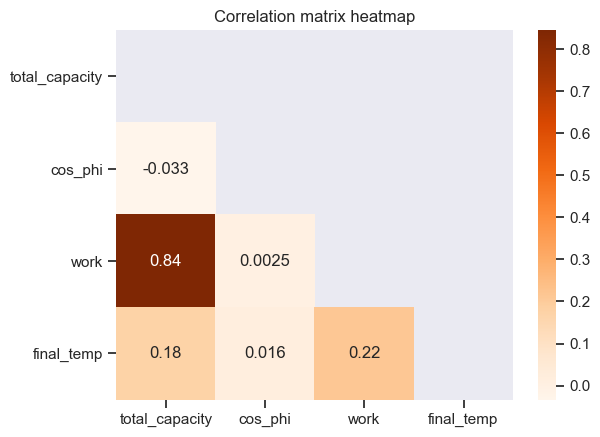

In [99]:
capacity_indicators = data_full[["total_capacity", "cos_phi", "work"]]
plot_corr_heatmap(
    data=capacity_indicators,
    target_var=data_full["final_temp"],
    annotation=True,
    heatmap_coloring="Oranges",
    lower_triangle=True,
)

It can be seen that only `total_capacity` and `work` affect target variable the most. We cannot leave both of them due to the presence of linear or unlinear dependence between them so we will just take the best one - `work`.

In [100]:
data_full.drop(["total_capacity", "cos_phi"], axis=1, inplace=True)

## Data cleaning

Now, let's consider the entire data and see its correlation matrix heatmap.

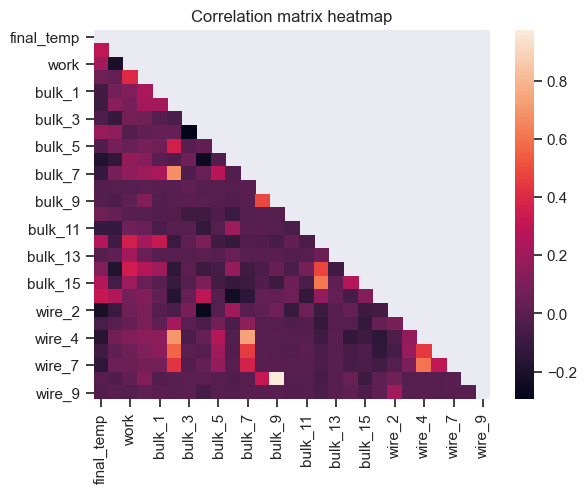

In [101]:
plot_corr_heatmap(data=data_full, lower_triangle=True)

In the next cells we will be looking for brightly highlighted aread in the heatmap and get rid of such factors. We will stop with multicollinear factor deletion as soon as we reach correlation values less than 0.6.

In [102]:
data_full[["wire_8", "bulk_9"]].corr()

,wire_8,bulk_9
wire_8,1.000000,0.974969
bulk_9,0.974969,1.000000


In [103]:
data_full.drop("bulk_9", axis=1, inplace=True)

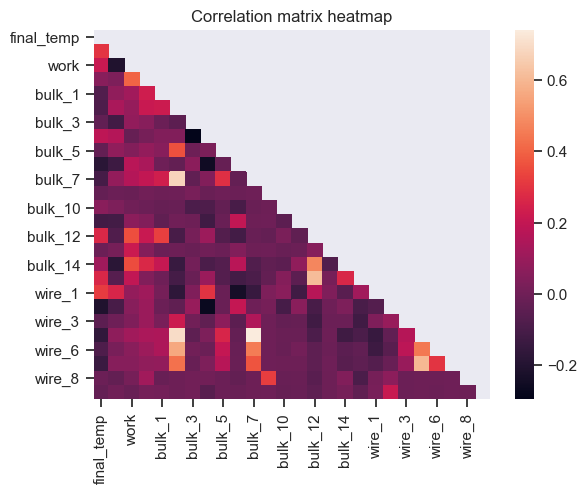

In [104]:
plot_corr_heatmap(data=data_full, lower_triangle=True)

In [105]:
data_full[["wire_4", "bulk_7"]].corr()

,wire_4,bulk_7
wire_4,1.000000,0.740572
bulk_7,0.740572,1.000000


In [106]:
data_full.drop("wire_4", axis=1, inplace=True)

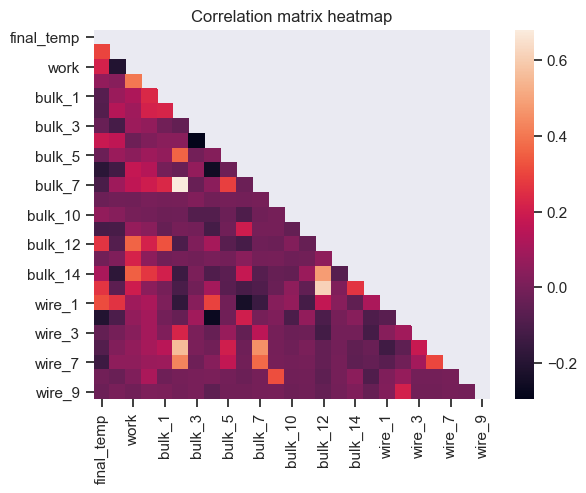

In [107]:
plot_corr_heatmap(data=data_full, lower_triangle=True)

In [108]:
data_full[["bulk_2", "bulk_7"]].corr()

,bulk_2,bulk_7
bulk_2,1.000000,0.679356
bulk_7,0.679356,1.000000


In [109]:
data_full.drop("bulk_2", axis=1, inplace=True)

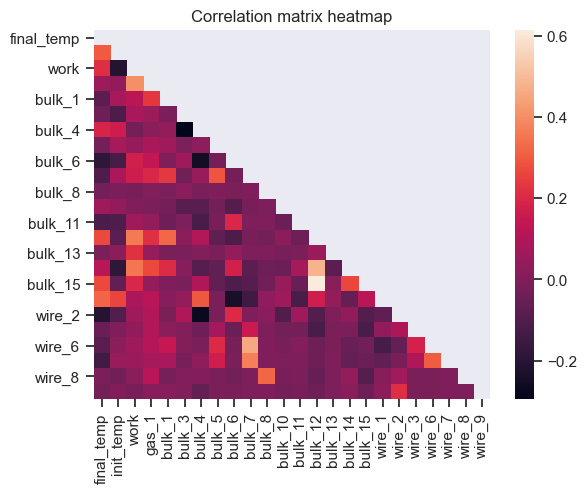

In [110]:
plot_corr_heatmap(data=data_full, lower_triangle=True)

In [111]:
data_full[["bulk_12", "bulk_15"]].corr()

,bulk_12,bulk_15
bulk_12,1.000000,0.614479
bulk_15,0.614479,1.000000


In [112]:
data_full.drop("bulk_15", axis=1, inplace=True)

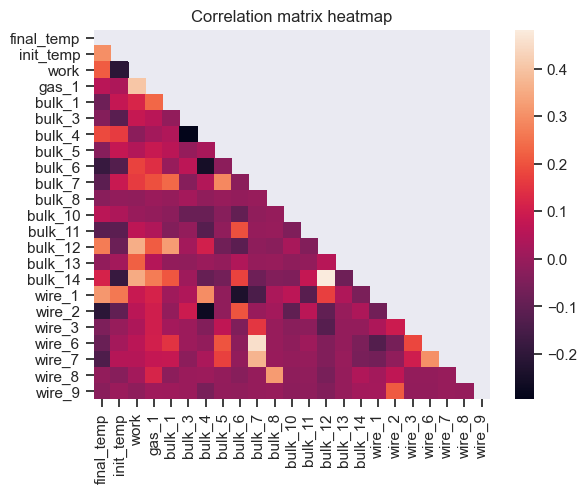

In [113]:
plot_corr_heatmap(data=data_full, lower_triangle=True)

In [114]:
data_full[["bulk_14", "bulk_12"]].corr()

,bulk_14,bulk_12
bulk_14,1.000000,0.481541
bulk_12,0.481541,1.000000


We now see that the highest correlation between features is about 0.48 so we will stop now. Let's see which features affect target variable the most.

In [115]:
print(f"Number of objects: {data_full.shape[0]:,}")
print(f"Number of features: {data_full.shape[1] - 1:,}")

Number of objects: 2,329
Number of features: 22


In [116]:
np.abs(data_full.corr()["final_temp"]).sort_values(ascending=False)[1:]

wire_1       0.317575
init_temp    0.301320
bulk_12      0.267424
work         0.215385
wire_2       0.206672
bulk_4       0.187970
bulk_6       0.181816
wire_7       0.137262
bulk_11      0.114753
bulk_14      0.114617
bulk_7       0.107275
wire_6       0.084034
bulk_1       0.075206
bulk_10      0.061350
gas_1        0.059160
wire_3       0.047537
bulk_3       0.035977
bulk_5       0.028355
wire_9       0.027488
bulk_8       0.026587
bulk_13      0.010920
wire_8       0.010767
Name: final_temp, dtype: float64

**Conclusion**

This section was dedicated to preprocessing multicollinear columns in the data we have merge. Thanks to correlation matrices we have managed to get rid of multicollinear variables and restrict correlations in the resulting DataFrame to values less than 0.6.

# Modeling

We now move on to modeling. In this section we will prepare data for machine learning algorithms, conduct cross-validation as well as grid search for hyperparameter optimization.

## Splitting data

In [117]:
# Separating features from target
target = data_full["final_temp"]
features = data_full.drop("final_temp", axis=1)

# Splitting data into training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

Let's verify if we have correctly divided the data into sets.

In [118]:
# Manually computing set shares
train_share_features = features_train.shape[0] / data_full.shape[0]
test_share_features = features_test.shape[0] / data_full.shape[0]
train_share_target = target_train.shape[0] / data_full.shape[0]
test_share_target = target_test.shape[0] / data_full.shape[0]

# Verification
assert (
    np.round(train_share_features, 2)
    == np.round(train_share_target, 2)
    == 1 - TEST_SIZE
)
assert np.round(test_share_features, 2) == np.round(test_share_target, 2) == TEST_SIZE

## Preprocessing pipelines

Before defining pipelines we will use for additional data preprocessing, let's list all models we will hereby use:
    
    1. Linear models
        a. LinearRegression
        b. RidgeRegression
        c. Lasso
    2. Tree-based ML models
        a. DecisionTreeRegressor
        b. RandomForestRegressor
    3. Gradient boosting models
        a. CatBoostRegressor
        b. XGBRegressor
        c. LGBMRegressor

As seen above, we will consider three classes of models: linear models (including those used for dealing with multicollinearity), machine learning tree-based algorithms and gradient boosting realizations. Before training, data will be scaled using `StandardScaler`.

In [119]:
scaler = StandardScaler()

In [120]:
# Linear models
lr_model = LinearRegression()
rr_model = Ridge(alpha=0.1, random_state=RANDOM_STATE)
lasso_model = Lasso(alpha=0.1, random_state=RANDOM_STATE)

# Pipelines for linear models
lr_pipeline = make_pipeline(scaler, lr_model)
rr_pipeline = make_pipeline(scaler, rr_model)
lasso_pipeline = make_pipeline(scaler, lasso_model)

In [121]:
# Tree-based models
dt_model = DecisionTreeRegressor(random_state=RANDOM_STATE)
rf_model = RandomForestRegressor(random_state=RANDOM_STATE)

# Pipelines for tree-based models
dt_pipeline = make_pipeline(scaler, dt_model)
rf_pipeline = make_pipeline(scaler, rf_model)

In [122]:
# Gradient boosting models
ctb_model = CatBoostRegressor(verbose=0)
xgb_model = XGBRegressor()
lgbm_model = LGBMRegressor()

# Pipelines for gradient boosting models
ctb_pipeline = make_pipeline(scaler, ctb_model)
xgb_pipeline = make_pipeline(scaler, xgb_model)
lgbm_pipeline = make_pipeline(scaler, lgbm_model)

## Hyperparameter grids

It does not make much sense to conduct grid search for linear models so for them we will just use a simple cross-validation. For other models, however, we will define hyperparameter grids.

In [123]:
pp = PrettyPrinter(depth=4)

### Tree-based ML models

In [124]:
dt_grid = {
    "decisiontreeregressor__max_depth": np.arange(1, 16),
}
pp.pprint(dt_grid)

{'decisiontreeregressor__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])}


In [125]:
rf_grid = {
    "randomforestregressor__max_depth": np.arange(1, 6),
    "randomforestregressor__n_estimators": np.arange(10, 60, step=10),
}
pp.pprint(rf_grid)

{'randomforestregressor__max_depth': array([1, 2, 3, 4, 5]),
 'randomforestregressor__n_estimators': array([10, 20, 30, 40, 50])}


### Gradient boosting models

In [126]:
ctb_grid = {
    "catboostregressor__max_depth": np.arange(1, 7),
    "catboostregressor__n_estimators": np.arange(10, 80, step=10),
    "catboostregressor__learning_rate": np.arange(0.01, 1.01, step=0.01),
}
pp.pprint(ctb_grid)

{'catboostregressor__learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
 'catboostregressor__max_depth': array([1, 2, 3, 4, 5, 6]),
 'catboostregressor__n_estimators': array([10, 20, 30, 40, 50, 60, 70])}


In [127]:
xgb_grid = {
    "xgbregressor__max_depth": np.arange(1, 7),
    "xgbregressor__n_estimators": np.arange(10, 80, step=10),
    "xgbregressor__learning_rate": np.arange(0.01, 1.01, step=0.01),
}
pp.pprint(xgb_grid)

{'xgbregressor__learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
 'xgbregressor__max_depth': array([1, 2, 3, 4, 5, 6]),
 'xgbregressor__n_estimators': array([10, 20, 30, 40, 50, 60, 70])}


In [128]:
lgbm_grid = {
    "lgbmregressor__max_depth": np.arange(1, 7),
    "lgbmregressor__n_estimators": np.arange(10, 80, step=10),
    "lgbmregressor__learning_rate": np.arange(0.01, 1.01, step=0.01),
}
pp.pprint(lgbm_grid)

{'lgbmregressor__learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
 'lgbmregressor__max_depth': array([1, 2, 3, 4, 5, 6]),
 'lgbmregressor__n_estimators': array([10, 20, 30, 40, 50, 60, 70])}


It can be noticed we have defined exactly the same hyperparameters and its values. In this case, as will be shown later, we will calibrate random number generator to actually go in different ways for these models when searching for optimal combinations. 

## Cross-validation

### `LinearRegression`

In [129]:
lr_scores = cross_val_score(
    estimator=lr_pipeline, X=features_train, y=target_train, cv=CV_FOLDS, scoring=SCORER
)
lr_score = np.abs(np.mean(lr_scores))

model_name = type(lr_pipeline["linearregression"]).__name__
print(f"Model: {model_name}")
print(f"MAE: {lr_score:.4f}")

Model: LinearRegression
MAE: 6.6708


### `Ridge`

In [130]:
rr_scores = cross_val_score(
    estimator=rr_pipeline, X=features_train, y=target_train, cv=CV_FOLDS, scoring=SCORER
)
rr_score = np.abs(np.mean(rr_scores))

model_name = type(rr_pipeline["ridge"]).__name__
print(f"Model: {model_name}")
print(f"MAE: {rr_score:.4f}")

Model: Ridge
MAE: 6.6708


### `Lasso`

In [131]:
lasso_scores = cross_val_score(
    estimator=lasso_pipeline,
    X=features_train,
    y=target_train,
    cv=CV_FOLDS,
    scoring=SCORER,
)
lasso_score = np.abs(np.mean(lasso_scores))

model_name = type(lasso_pipeline["lasso"]).__name__
print(f"Model: {model_name}")
print(f"MAE: {lasso_score:.4f}")

Model: Lasso
MAE: 6.6826


## Grid search

### Tree-based models

#### `DecisionTreeRegressor`

In [132]:
dt_grid_search = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions=dt_grid,
    n_iter=N_ITERS,
    scoring=SCORER,
    cv=CV_FOLDS,
    verbose=VERBOSITY,
    random_state=RANDOM_STATE,
)

dt_grid_search.fit(features_train, target_train)

print(f"Best parameters: {dt_grid_search.best_params_}")
print(f"Best score: {-dt_grid_search.best_score_:.4f}")

Best parameters: {'decisiontreeregressor__max_depth': 5}
Best score: 7.5180


#### `RandomForestRegressor`

In [133]:
rf_grid_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_grid,
    n_iter=N_ITERS,
    scoring=SCORER,
    cv=CV_FOLDS,
    verbose=VERBOSITY,
    random_state=RANDOM_STATE,
)

rf_grid_search.fit(features_train, target_train)

print(f"Best parameters: {rf_grid_search.best_params_}")
print(f"Best score: {-rf_grid_search.best_score_:.4f}")

Best parameters: {'randomforestregressor__n_estimators': 40, 'randomforestregressor__max_depth': 5}
Best score: 6.8104


### Gradient boosting models

In order to tell grid search algorithm to choose different paths of varied combination of hyperparameters, we will define *RandomState* instance with our random seed `RANDOM_STATE`.

In [134]:
state = np.random.RandomState(RANDOM_STATE)

#### `CatBoostRegressor`

In [135]:
ctb_grid_search = RandomizedSearchCV(
    estimator=ctb_pipeline,
    param_distributions=ctb_grid,
    n_iter=N_ITERS,
    scoring=SCORER,
    cv=CV_FOLDS,
    verbose=VERBOSITY,
    random_state=state,
)

ctb_grid_search.fit(features_train, target_train)

print(f"Best parameters: {ctb_grid_search.best_params_}")
print(f"Best score: {-ctb_grid_search.best_score_:.4f}")

Best parameters: {'catboostregressor__n_estimators': 40, 'catboostregressor__max_depth': 6, 'catboostregressor__learning_rate': 0.35000000000000003}
Best score: 6.5778


#### `XGBRegressor`

In [136]:
xgb_grid_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_grid,
    n_iter=N_ITERS,
    scoring=SCORER,
    cv=CV_FOLDS,
    verbose=VERBOSITY,
    random_state=state,
)

xgb_grid_search.fit(features_train, target_train)

print(f"Best parameters: {xgb_grid_search.best_params_}")
print(f"Best score: {-xgb_grid_search.best_score_:.4f}")

Best parameters: {'xgbregressor__n_estimators': 60, 'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.13}
Best score: 6.5568


#### `LGBMRegressor`

In [137]:
lgbm_grid_search = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=lgbm_grid,
    n_iter=N_ITERS,
    scoring=SCORER,
    cv=CV_FOLDS,
    verbose=VERBOSITY,
    random_state=state,
)

lgbm_grid_search.fit(features_train, target_train)

print(f"Best parameters: {lgbm_grid_search.best_params_}")
print(f"Best score: {-lgbm_grid_search.best_score_:.4f}")

Best parameters: {'lgbmregressor__n_estimators': 70, 'lgbmregressor__max_depth': 6, 'lgbmregressor__learning_rate': 0.05}
Best score: 6.6437


## Model comparison

Now, we can visualize the results of hyperparameter optimization. Using a list of tuples with model names and their respective cross-validated scores, we will plot the results and will choose the model with the smallest score (*Mean Absolute Error*, in our case).

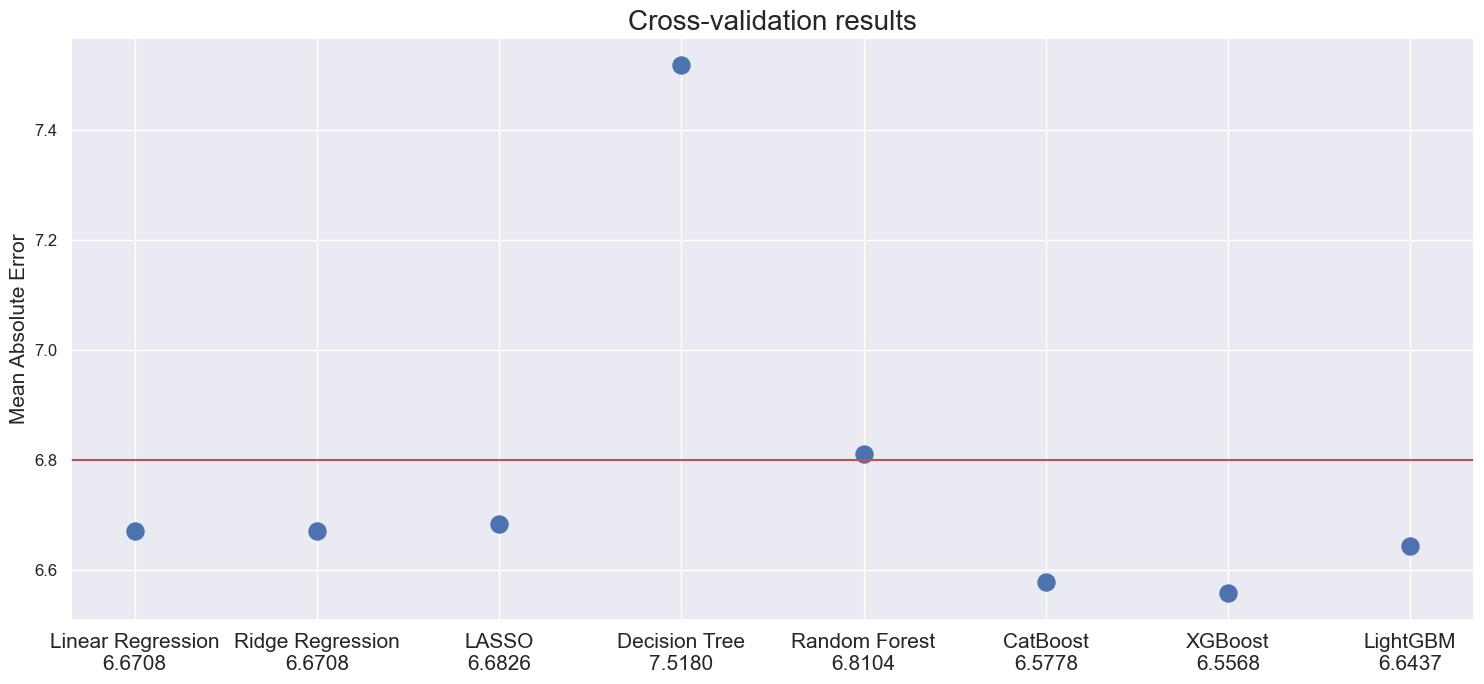

In [138]:
results = [
    ("Linear Regression", lr_score),
    ("Ridge Regression", rr_score),
    ("LASSO", lasso_score),
    ("Decision Tree", -dt_grid_search.best_score_),
    ("Random Forest", -rf_grid_search.best_score_),
    ("CatBoost", -ctb_grid_search.best_score_),
    ("XGBoost", -xgb_grid_search.best_score_),
    ("LightGBM", -lgbm_grid_search.best_score_),
]

names, scores = zip(*results)
names_with_scores = ["%s\n%.4f" % (name, loss) for name, loss in results]

plt.figure(figsize=(15, 7))
plt.scatter(range(len(results)), scores, s=150)
plt.xticks(range(len(results)), names_with_scores, fontsize=15)
plt.yticks(fontsize=12)
plt.title("Cross-validation results", fontsize=20)
plt.ylabel("Mean Absolute Error", fontsize=15)
plt.axhline(y=MAE_THRESHOLD, color="r", linestyle="-")
plt.tight_layout()
plt.show()

We can see that `LinearRegression` and `Ridge` produced approximately the same scores. This is probably the result of having gotten rid of multicollinear features in one of the previous sections. In this case, using regularization adjusted regression coefficients a little and resulted in small metric change. Other models generated not very outstanding results, but `XGBoost` model is seen to be quite promising. We will choose it as the model with the smallest *MAE* on cross-validation and will test it later.

## Feature importances

Now, let's consider what features were particuarly important for prediction in the winner-model.

In [139]:
final_grid = xgb_grid_search
final_model = xgb_grid_search.best_estimator_

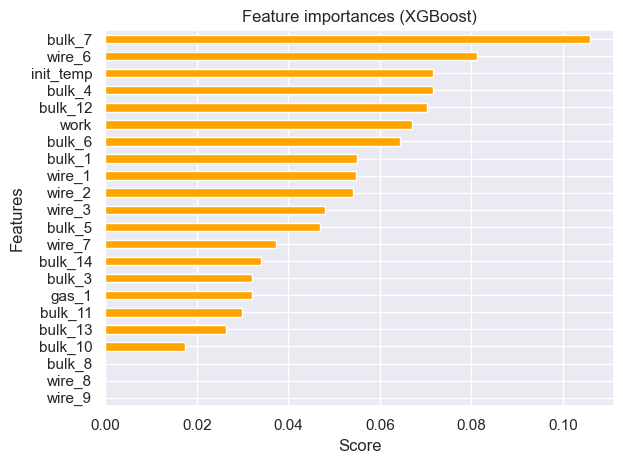

In [140]:
feature_importances = pd.Series(
    final_model["xgbregressor"].feature_importances_,
    index=final_model["standardscaler"].get_feature_names_out(),
).sort_values()

feature_importances.plot(kind="barh", color="orange")

plt.title("Feature importances (XGBoost)")
plt.ylabel("Features")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

We notice that a lot of factors proved to be important for the model (except for the last three features). Notably, features we have engineered (`init_temp` and `work`) appear to be in the top-10 most important factors.

**Conclusion**

This section was dedicated to hyperparameter optimization exercise. We have also cross-validated linear models and compared their results with those of other models. The most promising model appears to be gradient boosting realization from `xgboost` library.

# Testing the final model

## Computing test *MAE*

In [141]:
mae_test = -final_grid.score(features_test, target_test)

print(f"MAE (test): {mae_test:.2f}")

assert mae_test < MAE_THRESHOLD

MAE (test): 6.68


In [142]:
final_grid.best_params_

{'xgbregressor__n_estimators': 60,
 'xgbregressor__max_depth': 4,
 'xgbregressor__learning_rate': 0.13}

## Adequacy check

In [143]:
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(features_train, target_train)
predictions_dummy = dummy_model.predict(features_test)
mae_dummy = mean_absolute_error(predictions_dummy, target_test)

print(f"Dummy MAE (test): {mae_dummy:.2f}")

assert mae_test < mae_dummy

Dummy MAE (test): 8.22


**Conclusion**

We have managed to test the model for quality as well as adequacy. The model passed all checks and can be considered to be final.

# Conclusion

This study was devoted to building a prototype of the model for predicting the final temperature of steel pouring at the enterprise. We were able to get acquainted with the data, as well as explore their most problematic aspects. In particular, this related to the missing values as well as outliers. After performing preprocessing, we created several new features that ended up being useful for the model. The data were further merged and used in the optimization of hyperparameters for a number of considered models. The `XGBoost` gradient boosting implementation model with 60 trees (depth 4) and a learning rate of 0.13 proved to be the best model. The model not only passed the threshold of the required quality, but also appears to be adequate.